# Code for the paper

### Plotting imports and notebook configuration

In [1]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, image, input_data, plotting

In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## Listing 1

In [2]:
import nimare
sl_dset1 = nimare.io.convert_sleuth_to_dataset("data/contrast-CannabisMinusControl_space-talairach_sleuth.txt")
sl_dset2 = nimare.io.convert_sleuth_to_dataset("data/contrast-ControlMinusCannabis_space-talairach_sleuth.txt")

## Listing 2

In [3]:
if not os.path.isfile("data/neurosynth_dataset.pkl.gz"):
    nimare.extract.fetch_neurosynth("data/", unpack=True)
    ns_dset = nimare.io.convert_neurosynth_to_dataset(
        "data/database.txt",
        "data/features.txt"
    )
else:
    ns_dset = nimare.dataset.Dataset.load("data/neurosynth_dataset.pkl.gz")

## Listing 3

In [ ]:
from nimare.meta import kernel

mkda_kernel = kernel.MKDAKernel(r=10)
mkda_ma_maps = mkda_kernel.transform(sl_dset1, return_type="image")
kda_kernel = kernel.KDAKernel(r=10)
kda_ma_maps = kda_kernel.transform(sl_dset1, return_type="image")
ale_kernel = kernel.ALEKernel(sample_size=20)
ale_ma_maps = ale_kernel.transform(sl_dset1, return_type="image")

### Figure 3

In [ ]:
max_value = np.max(kda_ma_maps[0].get_fdata()) + 1

fig, axes = plt.subplots(nrows=3, figsize=(10, 10))
plotting.plot_stat_map(
    mkda_ma_maps[2], cut_coords=[54, -46, 12], 
    title="MKDA", vmax=max_value, axes=axes[0], 
    draw_cross=False
)
plotting.plot_stat_map(
    kda_ma_maps[2], cut_coords=[54, -46, 12], 
    title="KDA", vmax=max_value, axes=axes[1], 
    draw_cross=False
)
plotting.plot_stat_map(
    ale_ma_maps[2], cut_coords=[54, -46, 12], 
    title="ALE", axes=axes[2], 
    draw_cross=False
)
fig.show()

## Listing 4

In [ ]:
from nimare.meta.cbma import mkda

mkdad_meta = mkda.MKDADensity(null_method="analytic")
mkdad_results = mkdad_meta.fit(sl_dset1)

## Listing 5

In [ ]:
from nimare.meta.cbma import ale

ijk = ns_dset.coordinates[["i", "j", "k"]].values
meta = ale.SCALE(n_iters=250, ijk=ijk, kernel__sample_size=20)
scale_results = meta.fit(sl_dset1)

## Listing 6

In [ ]:
from nimare.meta.cbma import mkda

meta = mkda.MKDAChi2()
mkdac_results = meta.fit(sl_dset1, sl_dset2)

### Figure 4

In [ ]:
# Additional meta-analyses for figures
meta = mkda.KDA(null_method="empirical", n_iters=10000)
kda_results = meta.fit(sl_dset1)

meta = ale.ALE(null_method="analytic")
ale_results = meta.fit(sl_dset1)

# Meta-analytic maps across estimators
results = [mkdad_results, mkdac_results, kda_results, ale_results, scale_results]
names = ["MKDADensity", "MKDAChi2", "KDA", "ALE", "SCALE"]
for i, r in enumerate(results):
    name = names[i]
    if "z" in r.maps.keys():
        stat_img = r.get_map("z", return_type="image")
    else:
        stat_img = r.get_map("z_desc-consistency", return_type="image")
    plotting.plot_stat_map(
        stat_img, 
        title=name,
        cut_coords=[0, 0, 0],
        draw_cross=False,
        annotate=False,
    )

## Listing 7

In [ ]:
from nimare.meta import ibma
from nimare.tests.utils import get_test_data_path

dset_dir = nimare.extract.download_nidm_pain()
dset_file = os.path.join(get_test_data_path(), "nidm_pain_dset.json")
img_dset = nimare.dataset.Dataset(dset_file)
img_dset.update_path(dset_dir)

# Calculate missing images
img_dset.images = nimare.transforms.transform_images(
    img_dset.images, target="z", masker=img_dset.masker, metadata_df=img_dset.metadata
)
img_dset.images = nimare.transforms.transform_images(
    img_dset.images, target="varcope", masker=img_dset.masker, metadata_df=img_dset.metadata
)

meta = ibma.DerSimonianLaird()
dsl_results = meta.fit(img_dset)

### Figure 5

In [ ]:
# Additional meta-analyses for figures
meta = ibma.Stouffers(use_sample_size=False)
stouffers_results = meta.fit(img_dset)

meta = ibma.Stouffers(use_sample_size=True)
weighted_stouffers_results = meta.fit(img_dset)

meta = ibma.Fishers()
fishers_results = meta.fit(img_dset)

meta = ibma.PermutedOLS()
ols_results = meta.fit(img_dset)

meta = ibma.WeightedLeastSquares()
wls_results = meta.fit(img_dset)

meta = ibma.Hedges()
hedges_results = meta.fit(img_dset)

# Use atlas for likelihood-based estimators
atlas = datasets.fetch_atlas_smith_2009()
masker = input_data.NiftiMapsMasker(atlas["rsn70"])

meta = ibma.VarianceBasedLikelihood(method="reml", mask=masker)
vbl_results = meta.fit(img_dset)

meta = ibma.SampleSizeBasedLikelihood(method="reml", mask=masker)
ssbl_results = meta.fit(img_dset)

# Plot statistical maps from IBMAs
results = [
    dsl_results, 
    stouffers_results, 
    weighted_stouffers_results, 
    fishers_results, 
    ols_results, 
    wls_results, 
    hedges_results, 
    vbl_results, 
    ssbl_results
]
for r in results:
    img = r.get_map("z")
    plotting.plot_stat_map(img, cut_coords=[5, -15, 10])

## Listing 8

In [ ]:
from nimare.correct import FWECorrector

mc_corrector = FWECorrector(method="montecarlo", n_iters=100, n_cores=1)
mc_results = mc_corrector.transform(mkdad_meta.results)

b_corrector = FWECorrector(method="bonferroni")
b_results = b_corrector.transform(mkdad_meta.results)

### Figure 6

## Listing 9

In [ ]:
kern = kernel.ALEKernel()
meta = ale.ALESubtraction(kernel_transformer=kern, n_iters=10000)
subtraction_results = meta.fit(sl_dset1, sl_dset2)

### Figure 7

In [ ]:
stat_img = subtraction_results.get_map("z_desc-group1MinusGroup2", return_type="image")
plotting.plot_stat_map(
    stat_img, 
    title="ALE Subtraction",
    cut_coords=[0, 0, 0],
    draw_cross=False,
    annotate=False,
)

## Listing 10

In [4]:
# Create amygdala mask for MACMs
atlas = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr25-2mm")
amygdala_mask = image.math_img("img == 54", img=atlas["maps"])
amygdala_mask.to_filename("data/amygdala_roi.nii.gz")

amygdala_ids = ns_dset.get_studies_by_mask("data/amygdala_roi.nii.gz")
dset_amygdala = ns_dset.slice(amygdala_ids)

sphere_ids = ns_dset.get_studies_by_coordinate([[24, -2, -20]], r=6)
dset_sphere = ns_dset.slice(sphere_ids)

## Listing 11

In [5]:
from nimare.meta.cbma import ale

meta_amyg = ale.ALE(kernel__sample_size=20)
results_amyg = meta_amyg.fit(dset_amygdala)

meta_sphere = ale.ALE(kernel__sample_size=20)
results_sphere = meta_sphere.fit(dset_sphere)

### Figure 8

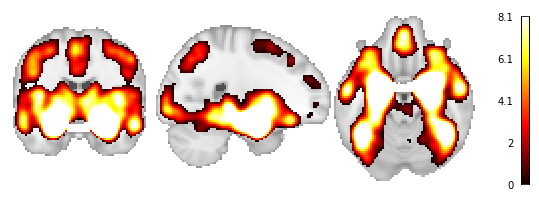

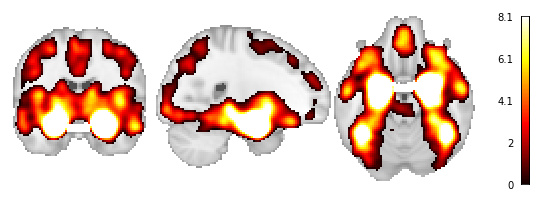

In [6]:
plotting.plot_stat_map(
    results_amyg.get_map("z"), 
    cut_coords=[24, -2, -20],
    draw_cross=False,
    annotate=False,
)
plotting.plot_stat_map(
    results_sphere.get_map("z"), 
    cut_coords=[24, -2, -20],
    draw_cross=False,
    annotate=False,
)

In [7]:
meta_amyg = mkda.MKDADensity(null_method="analytic")
results_amyg = meta_amyg.fit(dset_amygdala)

meta_sphere = mkda.MKDADensity(null_method="analytic")
results_sphere = meta_sphere.fit(dset_sphere)

plotting.plot_stat_map(
    results_amyg.get_map("z"), 
    cut_coords=[24, -2, -20],
    draw_cross=False,
    annotate=False,
)
plotting.plot_stat_map(
    results_sphere.get_map("z"), 
    cut_coords=[24, -2, -20],
    draw_cross=False,
    annotate=False,
)

NameError: name 'mkda' is not defined

In [8]:
meta_amyg = mkda.KDA()
results_amyg = meta_amyg.fit(dset_amygdala)

meta_sphere = mkda.KDA()
results_sphere = meta_sphere.fit(dset_sphere)

plotting.plot_stat_map(
    results_amyg.get_map("z"), 
    cut_coords=[24, -2, -20],
    draw_cross=False,
    annotate=False,
)
plotting.plot_stat_map(
    results_sphere.get_map("z"), 
    cut_coords=[24, -2, -20],
    draw_cross=False,
    annotate=False,
)

NameError: name 'mkda' is not defined

## Listing 12

### Figure 9

## Listing 13

In [ ]:
dset_with_abstracts = nimare.extract.download_abstracts(
    dset, 
    email="example@email.com"
)

## Listing 14

In [ ]:
model = nimare.annotate.lda.LDAModel(
    dset_with_abstracts.texts, text_column="abstract", 
    n_topics=100, n_iters=10000)
model.fit()

### Table 1

In [ ]:
model.p_word_g_topic_

## Listing 15

In [ ]:
dset_first1000 = dset_with_abstracts.slice(
    dset_with_abstracts.ids[:1000])
counts_df = nimare.annotate.text.generate_counts(
    dset_first1000.texts, text_column="abstract", 
    tfidf=False, min_df=1, max_df=1.)
model = nimare.annotate.gclda.GCLDAModel(
    counts_df, dset_first1000.coordinates, 
    n_regions=2, n_topics=100, symmetric=2,
    mask=dset.masker.mask_img)
model.fit(n_iters=10000)

### Table 2

In [ ]:
model.p_word_g_topic_

### Figure 10

In [ ]:
from nilearn import image

topic_img_4d = model.masker.unmask(model.p_voxel_g_topic_)
for i in range(5):
    topic_img = image.index_img(topic_img_4d, index=i)
    plot_stat_map(topic_img)

## Listing 16

In [ ]:
from nimare.decode.continuous import CorrelationDecoder

decoder = CorrelationDecoder(feature_group="Neurosynth_tfidf",
                             frequency_threshold=0.001,
                             meta_estimator=mkda.MKDAChi2,
                             target_img="z_desc-specificity")
decoder.fit(ns_dset)
decoding_results = decoder.transform("pain_map.nii.gz")

### Figure 11

In [ ]:
plot_stat_map("pain_map.nii.gz")

### Table 3

In [ ]:
decoding_results

## Listing 17

In [ ]:
from nimare.decode.continuous import CorrelationDistributionDecoder

decoder = CorrelationDistributionDecoder(
    feature_group="Neurosynth_tfidf",
    frequency_threshold=0.001,
    target_img="z")
decoder.fit(ns_dset)
decoding_results = decoder.transform("pain_map.nii.gz")

### Table 4

In [ ]:
decoding_results

## Listing 18

In [ ]:
from nimare.decode.discrete import BrainMapDecoder

decoder = BrainMapDecoder(feature_group="Neurosynth_tfidf",
                          frequency_threshold=0.001,
                          u=0.05, correction="fdr_bh")
decoder.fit(ns_dset)
decoding_results = decoder.transform(amygdala_ids)

### Table 5

In [ ]:
decoding_results.sort_values(by="probReverse", ascending=False).head()

## Listing 19

In [ ]:
from nimare.decode.discrete import NeurosynthDecoder

decoder = NeurosynthDecoder(feature_group="Neurosynth_tfidf",
                            frequency_threshold=0.001,
                            u=0.05, correction="fdr_bh")
decoder.fit(ns_dset)
decoding_results = decoder.transform(amygdala_ids)

### Table 6

In [ ]:
decoding_results.sort_values(by="probReverse", ascending=False).head()